# Import Libraries

In [1]:
import openvino as ov
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load Models

In [4]:
core = ov.Core()

model_face = core.read_model(model='models/face-detection-adas-0001.xml')
compiled_model_face = core.compile_model(model = model_face, device_name = "CPU")

input_layer_face = compiled_model_face.input(0)
output_layer_face = compiled_model_face.output(0)

print("Input shape:", input_layer_face.shape)
print("output shape:", output_layer_face.shape)

model_emo = core.read_model(model='models/emotions-recognition-retail-0003.xml')
compiled_model_emo = core.compile_model(model = model_emo, device_name = "CPU")

input_layer_emo = compiled_model_emo.input(0)
output_layer_emo = compiled_model_emo.output(0)

print("Input shape:", input_layer_emo.shape)
print("output shape:", output_layer_emo.shape)

model_ag = core.read_model(model='models/age-gender-recognition-retail-0013.xml')
compiled_model_ag = core.compile_model(model = model_ag, device_name = "CPU")

input_layer_ag = compiled_model_ag.input(0)
output_layer_ag = compiled_model_ag.output

print("Input shape:", input_layer_ag.shape)
print("output shape:", output_layer_ag)

Input shape: [1,3,384,672]
output shape: [1,1,200,7]
Input shape: [1,3,64,64]
output shape: [1,5,1,1]
Input shape: [1,3,62,62]
output shape: <bound method PyCapsule.output of <CompiledModel:
inputs[
<ConstOutput: names[data] shape[1,3,62,62] type: f32>
]
outputs[
<ConstOutput: names[prob] shape[1,2,1,1] type: f32>,
<ConstOutput: names[age_conv3, fc3_a] shape[1,1,1,1] type: f32>
]>>


# Function

In [85]:
def preprocess(image, input_layer):
        N, input_channels, input_height, input_width = input_layer.shape

        resized_image = cv2.resize(image, (input_width, input_height))
        transposed_image = resized_image.transpose(2,0,1)
        input_image = np.expand_dims(transposed_image,0)
        
        return input_image

In [86]:
def find_faceboxes(image, results, confidence_threshold):
    results = results.squeeze()

    scores = results[:, 2]
    boxes  = results[:, -4:]

    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >= confidence_threshold]

    image_h, image_w, image_channels = image.shape
    face_boxes = face_boxes*np.array([image_w, image_h, image_w, image_h])
    face_boxes = face_boxes.astype(np.int64)

    return face_boxes, scores

In [87]:
def draw_faceboxes(image, face_boxes, scores):
    
    show_image = image.copy()

    for i in range(len(face_boxes)):
        xmin, ymin, xmax, ymax = face_boxes[i]
        cv2.rectangle(img=show_image, pt1=(xmin, ymin), pt2=(xmax, ymax), color=(0, 200, 0), thickness=2)

    return show_image

In [88]:
def draw_age_gender_emotion(face_boxes, image):

    fontScale = image.shape[1]/1000
    EMOTION_NAMES = ['netural', 'happy', 'sad', 'surprise', 'anger']
    show_image = image.copy()

    for i in range(len(face_boxes)):
        xmin, ymin, xmax, ymax = face_boxes[i]
        face = image[ymin:ymax, xmin:xmax]

        # --- emotion ---
        input_image = preprocess(face, input_layer_emo)
        results = compiled_model_emo([input_image])[output_layer_emo]

        results_emo = results.squeeze()
        index = np.argmax(results_emo)
        # --- emotion ---

        # --- age and gender ---
        input_ag = preprocess(face, input_layer_ag)
        results_ag = compiled_model_ag([input_ag])
        
        age, gender = results_ag[1], results_ag[0]

        age=np.squeeze(age)
        age = int(age*100)
        
        gender=np.squeeze(gender)
        if (gender[0]>=0.65):
            gender='female'
            box_color = (0, 0, 200)
            
        elif (gender[1]>=0.55):
            gender='male'
            box_color = (200, 200, 0)
            
        else:
            gender='unknown'

        # --- age and gender ---

        text = gender + ' ' + str(age) + ' ' + EMOTION_NAMES[index]
        cv2.putText(show_image, text, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, fontScale, box_color, 10)
        cv2.rectangle(img=show_image, pt1=(xmin, ymin), pt2=(xmax, ymax), color=(0, 200, 0), thickness=2)

    return show_image

# Do Inference

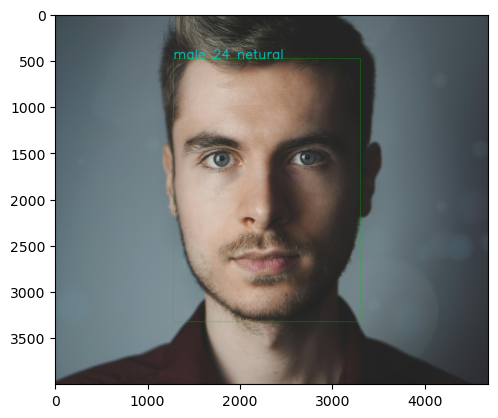

In [89]:
image = cv2.imread("data/person.jpg")

input_image = preprocess(image, input_layer_face)
results = compiled_model_face([input_image])[output_layer_face]

confidence_threshold = .06
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
show_image = draw_age_gender_emotion(face_boxes, image)

plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))